# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, theano will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


   
There is a template for your solution below that you can opt to use or throw away and write it your way.

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%env LIBRARY_PATH=/usr/local/cuda/lib64
import sys
sys.path.append("/home/shirobokov/.local/lib/python3.6/site-packages/")

env: CUDA_VISIBLE_DEVICES=0
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [2]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import torch

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from cifar import load_cifar10
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("/home/shirobokov/data/cifar_data")
class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print(X_train.shape,X_val.shape, X_test.shape)

(40000, 3, 32, 32) (10000, 3, 32, 32) (10000, 3, 32, 32)


In [5]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [65]:
model = torch.nn.Sequential()
model.add_module('conv_1', nn.Conv2d(3, 64, kernel_size=(3,3), stride=1, padding=0))
#model.add_module("maxpool_1", torch.nn.MaxPool2d(kernel_size=2))
model.add_module("bn1", torch.nn.BatchNorm2d(64))
model.add_module("relu_1", torch.nn.ReLU())
model.add_module('dropout_1', nn.Dropout(p=0.3))

model.add_module('conv_5', nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, padding=0))
model.add_module("maxpool_5", torch.nn.MaxPool2d(kernel_size=2))
model.add_module("bn5", torch.nn.BatchNorm2d(64))
model.add_module("relu_5", torch.nn.ReLU())
model.add_module('dropout_5', nn.Dropout(p=0.3))

model.add_module('conv_2', nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding=0))
model.add_module("maxpool_2", torch.nn.MaxPool2d(kernel_size=2))
model.add_module("bn2", torch.nn.BatchNorm2d(128))
model.add_module("relu_2", torch.nn.ReLU())
model.add_module('dropout_2', nn.Dropout(p=0.3))

model.add_module('conv_3', nn.Conv2d(128, 256, kernel_size=(3,3), stride=1, padding=0))
model.add_module("maxpool_3", torch.nn.MaxPool2d(kernel_size=2))
model.add_module("bn3", torch.nn.BatchNorm2d(256))
model.add_module("relu_3", torch.nn.ReLU())
model.add_module('dropout_3', nn.Dropout(p=0.5))          

model.add_module("flat", Flatten())

model.add_module("fc1", torch.nn.Linear(1024, 1024))
model.add_module("relu_4", torch.nn.ReLU())
model.add_module("dropout_4", torch.nn.Dropout(p=0.3))

model.add_module("fc_f", torch.nn.Linear(1024, 512))
model.add_module("relu_f", torch.nn.ReLU())
model.add_module("fc_final", torch.nn.Linear(512, 10))
#model.add_module("sigmoid", torch.nn.Sigmoid())

model.cuda(0)

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu_1): ReLU()
  (dropout_1): Dropout(p=0.3)
  (conv_5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool_5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu_5): ReLU()
  (dropout_5): Dropout(p=0.3)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (relu_2): ReLU()
  (dropout_2): Dropout(p=0.3)
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (maxpool_3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (relu_3): ReLU()
  (dropout_3): Dropout(p=0.5)
  (fla

In [64]:
model(Variable(torch.FloatTensor(X_val[:1])))

Variable containing:
1.00000e-02 *
 -7.8055 -1.4542 -4.6459 -7.2926  2.7837 -6.3223  4.4707 -7.7274 -1.2790 -6.8382
[torch.FloatTensor of size 1x10]

In [66]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda(0)
    y_batch = Variable(torch.LongTensor(y_batch)).cuda(0)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

__ Training __

In [67]:
from tqdm import trange
def iterate_minibatches(X, y, batchsize, shuffle=False):
    indices = np.arange(len(X))
    if shuffle: 
        indices = np.random.permutation(indices)
    for start in trange(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [73]:
import time
from pandas import ewma
from IPython import display        
        
opt = torch.optim.Adam(model.parameters(), lr=1e-3 / 2)

num_epochs = 95 # total amount of full passes over training data
batch_size = 1024  # number of samples processed in one SGD iteration

train_loss = []
val_accuracy = []

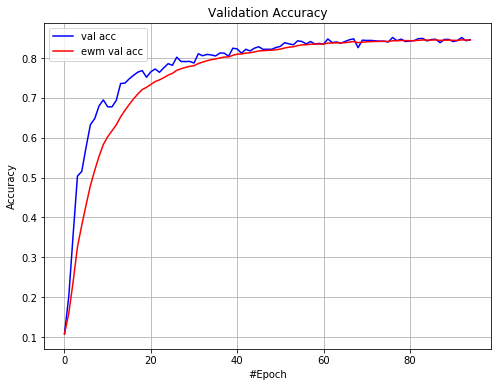

Epoch 15 of 15 took 12.796s
  training loss (in-iteration): 	0.268012
  validation accuracy:		84.61 %


In [74]:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy()[0])
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    y_score = []
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
        logits = model(Variable(torch.FloatTensor(X_batch)).cuda(0))
        y_pred = logits.max(1)[1].data.cpu().numpy()
        #val_accuracy.append(np.mean(y_batch == y_pred))
        y_score.extend(y_pred)

    y_score = np.asarray(y_score)
    val_accuracy.append(np.mean(y_score == y_val))
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.title("Validation Accuracy")
    plt.xlabel("#Epoch")
    plt.ylabel("Accuracy")
    plt.plot(val_accuracy, 'b',label='val acc')
    plt.plot(ewma(np.array(val_accuracy), span=10),'r',label='ewm val acc')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
            
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
#     print("  validation accuracy: \t\t\t{:.2f} %".format(
#         np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_accuracy[-1] * 100))

In [75]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(Variable(torch.FloatTensor(X_batch)).cuda(0))
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

100%|██████████| 20/20 [00:00<00:00, 23.29it/s]

Final results:
  test accuracy:		84.30 %
Achievement unlocked: 110lvl Warlock!


```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `___ ___`, and here's my story

A long ago in a galaxy far far away, when it was still more than an hour before deadline, i got an idea:

##### I gonna build a neural network, that
* brief text on what was
* the original idea
* and why it was so

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged and
* Some explaination about what were the results,
* what worked and what didn't
* most importantly - what next steps were taken, if any
* and what were their respective outcomes

##### Finally, after __  iterations, __ mugs of [tea/coffee]
* what was the final architecture
* as well as training method and tricks

That, having wasted ____ [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


[an optional afterword and mortal curses on assignment authors]

From the beginning I knew I will build ConvNet, using typical architecture, of Conv->BN->Pool->Nonlinearity->Dropout.
The only thing to find out was the right size of convs, about of this blocks, dropout rate.

I have started with the net similar to above, but has inital layer of 5x5 conv, followed by maxpool after, as well as Dropouts that all have 0.5 drop rate, and only one Dense layer in the end.

The resulted accuracy on validation of this setup was about 70% and what as worse, if was very unstable on validation set, whith predicted accuracy jumping. I first lowered the learning rate, but that did not help.

Then, I removed first conv 5x5 and made it 3x3, as well as remove first maxpool(otherwise I get too small image).
That already give me imporvement and made learning curve more stable.

Followed by this, I added one more dense layer in the end and lowered the dropout rate in the middle of conv part. As a result, I got stable learning curve, whith OK accuracy, which you can see above. If I have time, I may be play with augmentation, since I am sure this + sligh modification of net can result in abot 90% accuracy.

Currently, by final results are


* loss on training: 0.26
* accuracy on validation: 84.61%
* accuracy on test: 84.30%